In [1]:
from SheetsConversor import SheetsConversor
from Complete import CompleteCalculator
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import pandas as pd
import numpy as np
from matplotlib import cm
from func_timeout import func_timeout, FunctionTimedOut
from mpl_toolkits.mplot3d import axes3d
import plotly.graph_objects as go
import plotly.offline as py
from matplotlib.ticker import FuncFormatter

from global_search_recommendation.dominio import Dominio
from global_search_recommendation.BioInspiredRecomendation import BioInspiredRecomendation
from percentile_recommendation.percentiles import Percentiles
from percentile_recommendation.current_calculator import RecommendationCalculator
from commons.Tariff import BlueTariff, GreenTariff

In [2]:
## ao definir o target no conversor, apenas ele será utilizado

conversor = SheetsConversor('../sheets-plus/')
ucs, mods, contract = conversor.convert(target='../sheets-plus/UFPR.xlsx - 1936905')

Reading ../sheets-plus/UFPR.xlsx...
Done! 1 UCs conveted!


In [3]:
def thousands_formatter(x, pos):
    return f'{x/1000:,.1f}K'    
    
def plot_green_pattern(green):
    plt.plot(green.unique_demand, green.cost, label='Completo')

    percentiles_demands, demand_costs = Percentiles().get_green()
    total_costs = [ demand_cost + Dominio().consumption_cost_on_green for demand_cost in demand_costs ]

    plt.plot(percentiles_demands, total_costs, 'go', label="Percentis")
    
    plt.xlabel('Demanda Unica (kW)')
    plt.ylabel('Custo Total(R$)')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    #plt.title('Curva custo/demanda na modalidade Verde')
    plt.legend()
    plt.show()

def plot_blue_pattern(blue):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    percentiles_peak_demands, percentile_off_peak_demands, demand_costs = Percentiles().get_blue()
    total_costs = [ demand_cost + Dominio().consumption_cost_on_blue for demand_cost in demand_costs ]
    ax.plot(percentiles_peak_demands, percentile_off_peak_demands, total_costs, 'g.', label='Percentis', zorder=4)    

    surf = ax.plot_trisurf(blue['peak_demand'], blue['off_peak_demand'], blue['cost'], cmap='plasma', linewidth=0, antialiased=True)
    
    #ax.set_title('Superfície de custo modalidade Azul', fontsize=8)
    ax.set_xlabel('Demanda Ponta (kW)', fontsize=8)
    ax.set_ylabel('Demanda Fora de Ponta (kW)', fontsize=8)
    ax.set_zlabel('Custo Total (R$)', fontsize=6)

    ax.zaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    for label in ax.get_zticklabels():
        label.set_rotation(15)

    plt.legend()
    plt.show()
    #plt.savefig('azul-ufpr-33261296.png')

In [4]:
def plot_ga(green, blue):
    uniques = [ int(round(x[0])) for x in Dominio().ga_green_record ]
    optimal_unique = green[green.cost == green.cost.min()].unique_demand.values.max().astype(int)

    plt.plot(range(1, len(uniques)+1), uniques)
    plt.plot(range(1, len(uniques)+1), np.linspace(optimal_unique, optimal_unique, num=len(uniques)).astype(int), 'y--', label='Optimal value')

    plt.title('Demanda recomendada por iteração GA modalidade Verde', fontsize=8)
    plt.xlabel('Iteração', fontsize=8)
    plt.ylabel('Demanda única (Kw)', fontsize=8)
    plt.xticks(range(1, len(uniques)+1))

    plt.legend()
    plt.show()

    peaks = [ int(round(x[0])) for x in Dominio().ga_blue_record ]
    off_peaks = [ int(round(x[1])) for x in Dominio().ga_blue_record ]
    optimal_peak = blue[blue.cost == blue.cost.min()].peak_demand.values.max().astype(int)
    optimal_off_peak = blue[blue.cost == blue.cost.min()].off_peak_demand.values.max().astype(int)

    fig = plt.figure(figsize=(10, 5))
    print('Demanda recomendada por iteração GA modalidade Azul')
    
    ax = fig.add_subplot(1, 2, 1)
    
    ax.plot(range(1, len(peaks)+1), peaks)
    ax.plot(range(1, len(peaks)+1), np.linspace(optimal_peak, optimal_peak, num=len(peaks)).astype(int), 'y--', label='Optimal value')
    
    ax.set_title('Posto ponta', fontsize=8)
    ax.set_ylabel('Peak Demand (kw)', fontsize=8)
    ax.set_xlabel('Iterações', fontsize=8)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(range(1, len(off_peaks)+1), off_peaks)
    ax2.plot(range(1, len(off_peaks)+1), np.linspace(optimal_off_peak, optimal_off_peak, num=len(off_peaks)).astype(int), 'y--', label='Optimal value')

    ax2.set_title('Posto fora ponta', fontsize=8)
    ax2.set_ylabel('Off-Peak Demand (kw)', fontsize=8)
    ax2.set_xlabel('Iterações', fontsize=8)

    plt.legend()
    plt.show()
    

|------------------------------------------------------------------------------|
	 UC: ../sheets-plus/UFPR.xlsx - 1936905

Custo de consumo modalidade verde:  315072.49
Custo de consumo modalidade azul:   261839.14

Menor custo total modalidade verde: 364497.74 
	Demanda única: [350 351 352 353 354]

Menor custo total modalidade azul:  364606.43 
	Demanda ponta:         [194 194 194 194 194]
	Demanda fora de ponta: [350 351 352 353 354]



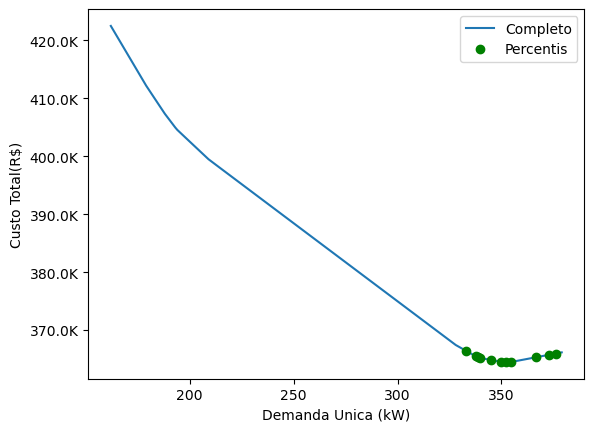

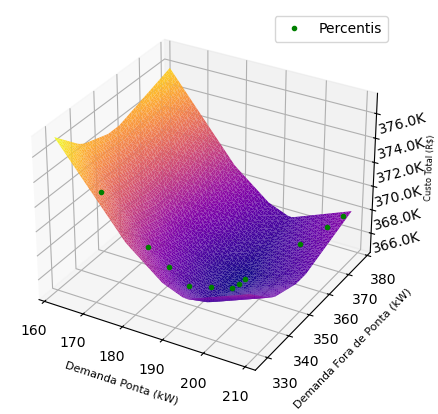

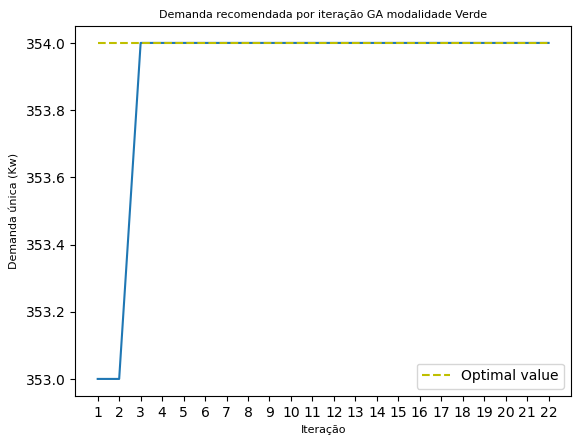

Demanda recomendada por iteração GA modalidade Azul


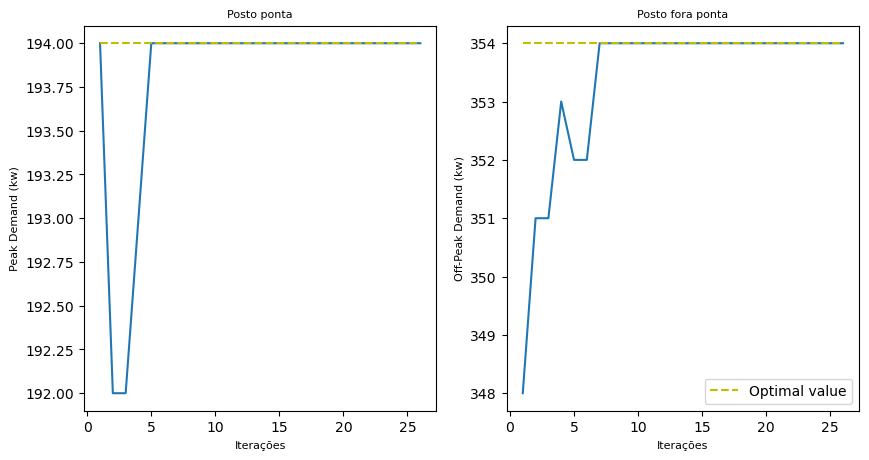

In [5]:
n = 6      # número de meses análisados, todas as ucs tem ao menos 12
num_ucs = 1  # número de ucs a serem processadas, é utilizada a ordem de conversão
time_out = 15 # timeout em segundos

i = 1
for uc in ucs:
    if i > num_ucs:
        break

    complete_calculator = CompleteCalculator(n, ucs[uc])
    cm = RecommendationCalculator(ucs[uc].head(n), mods[uc], BlueTariff(), GreenTariff(), n)
    bio = BioInspiredRecomendation(n, pd.DataFrame(ucs[uc]))
    
    try:
        _ = func_timeout(time_out, complete_calculator.run, kwargs={'save': True})
        _ = cm.calculate()
        _ = bio.do_GA(iterative=True, record=True)
        
        green, blue = complete_calculator.get_patterns(frame=True)
    except FunctionTimedOut:
        print("Timed-out, skiped...")
        continue

    i += 1
    print("|------------------------------------------------------------------------------|")
    print(f"\t UC: {uc}\n")
    print(f"Custo de consumo modalidade verde:  {round(Dominio().consumption_cost_on_green, 2)}")
    print(f"Custo de consumo modalidade azul:   {round(Dominio().consumption_cost_on_blue, 2)}\n")
    print(f"Menor custo total modalidade verde: {round(green.cost.min(), 2)} \n\tDemanda única: {green[green.cost == green.cost.min()].unique_demand.values.astype(int)}\n")
    print(f"Menor custo total modalidade azul:  {round(blue.cost.min(), 2)} \n\tDemanda ponta:         {blue[blue.cost == blue.cost.min()].peak_demand.values.astype(int)}\n\tDemanda fora de ponta: {blue[blue.cost == blue.cost.min()].off_peak_demand.values.astype(int)}\n")
   
    #_plot_green(green)
    plot_green_pattern(green)
    plot_blue_pattern(blue)
    plot_ga(green, blue)
    Percentiles().clear()

   